### 5. Feature Engineering and Improvement
#### Task 5: Feature Engineering

**Load Data and Baseline Model**

In [17]:
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

# Load processed data and model
data = joblib.load("../data/processed_data.pkl")
model_data = joblib.load("../models/best_model.pkl")  # Assuming this is the saved XGBoost

# Extract components if saved as dictionary (recommended format)
if isinstance(model_data, dict):
    model = model_data['model']
    best_params = model_data['params']
else:
    model = model_data
    best_params = model.get_params()

# Original features
original_features = ['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'TAX', 'RAD_4.0', 'CHAS']
X_train, y_train = data['X_train'][original_features], data['y_train']
X_test, y_test = data['X_test'][original_features], data['y_test']

# Verify early stopping parameters
print("Early stopping params:", {k: v for k, v in best_params.items() 
                                if k in ['early_stopping_rounds', 'eval_metric']})

Early stopping params: {'early_stopping_rounds': 10, 'eval_metric': 'rmse'}


**Feature Creation**

In [18]:
def create_features(df):
    """Create new features while preserving original columns"""
    df = df.copy()
    
    # 1. Interaction terms
    df['ROOMS_PER_TAX'] = df['RM'] / (df['TAX'] + 1e-6)
    df['LSTAT_RM_INTERACTION'] = df['LSTAT'] * df['RM']
    
    # 2. Non-linear transforms
    df['LSTAT_SQUARED'] = df['LSTAT'] ** 2
    
    # 3. Binning (XGBoost handles well)
    df['RM_BINNED'] = pd.cut(df['RM'], bins=5, labels=False)
    
    return df

# Apply to train/test
X_train_new = create_features(X_train)
X_test_new = create_features(X_test)


**Feature Evaluation**

In [19]:
# Update parameters (preserve original but adjust for new features)
params = {
    **best_params,
    'early_stopping_rounds': 10,  # Keep early stopping
    'eval_metric': 'rmse'
}

# Initialize and train
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(
    X_train_new, y_train,
    eval_set=[(X_test_new, y_test)],  # Required for early stopping
    verbose=True  # Shows training progress
)

# Evaluate
y_pred1 = xgb_model.predict(X_test_new)
rmse = root_mean_squared_error(y_test, y_pred1)
print(f"\nTest RMSE with new features: {rmse:.4f}")

[0]	validation_0-rmse:6.59109
[1]	validation_0-rmse:6.09231
[2]	validation_0-rmse:5.66884
[3]	validation_0-rmse:5.31730
[4]	validation_0-rmse:5.00687


[5]	validation_0-rmse:4.71203
[6]	validation_0-rmse:4.47469
[7]	validation_0-rmse:4.22984
[8]	validation_0-rmse:4.05078
[9]	validation_0-rmse:3.85484
[10]	validation_0-rmse:3.73278
[11]	validation_0-rmse:3.61718
[12]	validation_0-rmse:3.50484
[13]	validation_0-rmse:3.41756
[14]	validation_0-rmse:3.33890
[15]	validation_0-rmse:3.28851
[16]	validation_0-rmse:3.24337
[17]	validation_0-rmse:3.20162
[18]	validation_0-rmse:3.17585
[19]	validation_0-rmse:3.14975
[20]	validation_0-rmse:3.12926
[21]	validation_0-rmse:3.10057
[22]	validation_0-rmse:3.05747
[23]	validation_0-rmse:3.05611
[24]	validation_0-rmse:3.04834
[25]	validation_0-rmse:3.02941
[26]	validation_0-rmse:3.01381
[27]	validation_0-rmse:3.00082
[28]	validation_0-rmse:2.99970
[29]	validation_0-rmse:2.99845
[30]	validation_0-rmse:2.99042
[31]	validation_0-rmse:2.98685
[32]	validation_0-rmse:2.98297
[33]	validation_0-rmse:2.98202
[34]	validation_0-rmse:2.98656
[35]	validation_0-rmse:2.98741
[36]	validation_0-rmse:2.98580
[37]	validati

**Feature Importance Analysis**


In [20]:
if hasattr(xgb_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
print(importance)

   Feature  Importance
1    LSTAT    0.394299
0       RM    0.386335
2  PTRATIO    0.125500
4      TAX    0.056115
3    INDUS    0.032636
5  RAD_4.0    0.005115
6     CHAS    0.000000


<Figure size 1200x600 with 0 Axes>

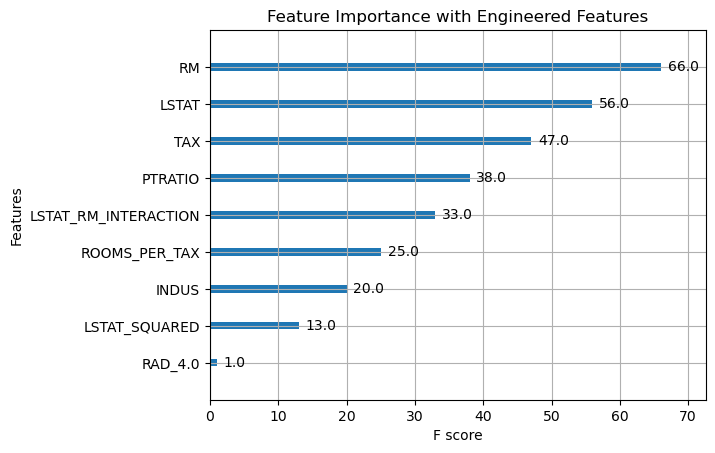

In [21]:
import matplotlib.pyplot as plt

# Native XGBoost importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title("Feature Importance with Engineered Features")
plt.show()

**Feature Selection**

In [22]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Create a new XGBoost model WITHOUT early stopping for feature selection
feature_selector_model = xgb.XGBRegressor(
    **{k: v for k, v in xgb_model.get_params().items() 
       if k not in ['early_stopping_rounds', 'eval_set']}
)

# Fit the selector
selector = SelectFromModel(
    estimator=feature_selector_model,
    threshold='median'
).fit(X_train_new.values, y_train)

# Get selected features
selected_mask = selector.get_support()
selected_features = X_train_new.columns[selected_mask]
print("Selected features:", list(selected_features))

# Transform datasets
X_train_selected = selector.transform(X_train_new.values)
X_test_selected = selector.transform(X_test_new.values)

print(f"\nReduced from {X_train_new.shape[1]} to {X_train_selected.shape[1]} features.")

Selected features: ['RM', 'LSTAT', 'PTRATIO', 'TAX', 'LSTAT_RM_INTERACTION', 'LSTAT_SQUARED']

Reduced from 11 to 6 features.


**Retrain Final Model with Selected Features (With Early Stopping)**

In [23]:
# Retrain with early stopping
final_model = xgb.XGBRegressor(**xgb_model.get_params())  # Keep original params
final_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_test_selected, y_test)],
    verbose=True
)

# Evaluate
y_pred2 = final_model.predict(X_test_selected)
rmse = root_mean_squared_error(y_test, y_pred2)
print(f"Test RMSE with selected features: {rmse:.4f}")

[0]	validation_0-rmse:6.59109
[1]	validation_0-rmse:6.09645
[2]	validation_0-rmse:5.66103
[3]	validation_0-rmse:5.32611
[4]	validation_0-rmse:4.97471
[5]	validation_0-rmse:4.68916
[6]	validation_0-rmse:4.43199
[7]	validation_0-rmse:4.21776
[8]	validation_0-rmse:3.99441
[9]	validation_0-rmse:3.84149
[10]	validation_0-rmse:3.68780
[11]	validation_0-rmse:3.58502
[12]	validation_0-rmse:3.48012
[13]	validation_0-rmse:3.40940
[14]	validation_0-rmse:3.35025
[15]	validation_0-rmse:3.30367
[16]	validation_0-rmse:3.25623
[17]	validation_0-rmse:3.21546
[18]	validation_0-rmse:3.18455
[19]	validation_0-rmse:3.15574
[20]	validation_0-rmse:3.13362
[21]	validation_0-rmse:3.12504
[22]	validation_0-rmse:3.10891
[23]	validation_0-rmse:3.08778
[24]	validation_0-rmse:3.07751
[25]	validation_0-rmse:3.07284
[26]	validation_0-rmse:3.06969
[27]	validation_0-rmse:3.06598
[28]	validation_0-rmse:3.05190
[29]	validation_0-rmse:3.03160
[30]	validation_0-rmse:3.02069
[31]	validation_0-rmse:3.02544
[32]	validation_0-

In [24]:
# printing the predictions vs real target variable
predictions = pd.DataFrame({'Real_MEDV': y_test,'Predicted_MEDV_with_all_FE_features': y_pred1,'Predicted_MEDV_With_Selected_FE_features': y_pred2}).sort_index()
print("\nReal MEDV vs Predicted MEDV\n", predictions)



Real MEDV vs Predicted MEDV
      Real_MEDV  Predicted_MEDV_with_all_FE_features  \
0         24.0                            26.815523   
2         34.7                            34.675591   
9         18.9                            19.472656   
11        18.9                            20.849352   
18        20.2                            19.010042   
..         ...                                  ...   
491       13.6                            15.323967   
496       19.7                            14.975777   
497       18.3                            20.578796   
500       16.8                            20.603016   
501       22.4                            19.455746   

     Predicted_MEDV_With_Selected_FE_features  
0                                   27.752552  
2                                   35.102020  
9                                   19.990583  
11                                  21.325897  
18                                  17.312366  
..                   

In [25]:
# Saving the files
predictions.to_csv('../data/predictions.csv')
importance.to_csv('../data/feature_importance.csv')